In [1]:
# package for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#package for time
from dateparser.search import search_dates
import datetime

# package for the regular expressions 
import re
import string

# package for the natural language toolkit 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud ,STOPWORDS

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Open the files that we use for analysis 

In [2]:
data = pd.read_csv('C:/Users/anis_/PycharmProjects/mywebscrap/bloom/bloom/spiders/echo3.csv' , encoding = 'utf-8')
data =data.dropna().reset_index(drop=True)
data['headline'] = data['headline'].astype(str)
data['description'] = data['description'].astype(str)
data

,headline,description,date
0,"Bourse: la rentabilité, point faible des entre...",Les entreprises de la vieille économie affiche...,"Publié le 22 août 2018 à 18h07,Mis à jour le 2..."
1,Barclays obligé de réembaucher un trader licen...,"Accusé d'avoir utilisé un outil controversé, l...","Publié le 22 août 2018 à 17h29,Mis à jour le 2..."
2,La Bourse chinoise a perdu plus du quart de sa...,"Depuis son pic de janvier, l'indice CSI 300 a ...",Publié le 22 août 2018 à 16h58
3,Luxe : Farfetch surfe sur l'intérêt des marché...,¤ Le site britannique spécialisé dans la mode ...,Publié le 22 août 2018 à 1h01
4,Coty chute en Bourse après des résultats décev...,Le groupe de cosmétique et de parfumerie a ann...,Publié le 22 août 2018 à 1h01
...,...,...,...
2092,"Coronavirus : Wall street dans le vert, entraî...","Wall Street a ouvert la semaine dans le vert, ...","Publié le 30 mars à 8h56,Mis à jour le 30 mars..."
2093,Coronavirus : ce qu'il faut retenir du 30 mars,La perspective que l'épidémie atteigne enfin s...,"Publié le 30 mars à 7h15,Mis à jour le 30 mars..."
2094,Bourse : Le grand Covid des dividendes,Les actionnaires du CAC 40 vont subir une chut...,Publié le 29 mars à 14h31
2095,Dividendes : une raison d'être solidaire,Le versement de dividendes par des entreprises...,"Édito,Publié le 29 mars à 13h32,Mis à jour le ..."


In [3]:
def set_dates():
    
    date_list = []
    
    #Use the search_dates to extract the date from a string 
    for i in data['date']:
        dates = search_dates(i)
        timestamp = dates[-1][-1]
        date_list.append(timestamp)
    
    data['timestamp'] = date_list
    data['Date'] = ""    
    
    #Convert out output into a date format 
    for i, x in data['timestamp'].iteritems():
        data['Date'].loc[i] = datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').date()
    
    return data.sort_values(by = 'Date', ascending=False).reset_index(drop=True)

In [4]:
def open_vix_file():
    df_vix = pd.read_csv('VIX.csv')
    
    for i, x in df_vix['Date'].iteritems():
        df_vix['Date'].loc[i] = datetime.datetime.strptime(str(x), '%Y-%m-%d').date()
    
    return df_vix

In [5]:
def new_dataset():
    
    data = set_dates()
    df_vix = open_vix_file()
    data['Open'] = ""
    data['Close'] = ""
    
    #we look at the date of the article and we try to find the corresponding values in the Vix file
    for x in range(data.shape[0]):
        for i in range(df_vix.shape[0]):
            if(data['Date'].loc[x] == df_vix['Date'].loc[i]):
                data['Open'].loc[x] = df_vix['Open'].loc[i]
                data['Close'].loc[x] = df_vix['Close'].loc[i]
                break
    
    # If the closing value is greater than the opening value, the news is negative = 1
    data.replace('', np.nan, inplace=True)
    data = data.dropna().reset_index(drop=True)
    
    data['article'] = data['headline'].str.cat(data['description'], sep = ".")
    data['article'] = data['article'].astype(str) 
    data['label'] = ""
    
    df = data.drop('date', axis=1)
    df = df.drop('timestamp', axis = 1)
    df.drop('headline', axis = 1, inplace = True)
    df.drop('description', axis = 1, inplace = True)

    
    for x in range(df.shape[0]):
        if (df['Close'].loc[x]-df['Open'].loc[x] >= 0):
            df['label'].loc[x] = 0
        else :
            df['label'].loc[x] = 1
    
    df = df[['article', 'Date', 'Open', 'Close', 'label']]
    
    return df

In [7]:
df_news = new_dataset()

### Analyse de nos données 

On regarde la répartition de nos données positives et négatives afin de se faire une idée de ce qu'on predira

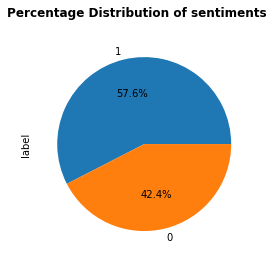

In [8]:
# label = data['label'].value_counts()
# print(label.plot.bar())

fig,ax1 = plt.subplots(1, 1, figsize=(8, 4))

pd.value_counts(df_news['label']).plot(kind = 'pie', ax=ax1,autopct='%1.1f%%')
plt.suptitle("Percentage Distribution of sentiments",fontweight = "bold")
plt.show()

On regarde si on a autant d'articles qui sont écrits par jour et par la suite voir par mois.
Par la suite, voir combien on en a de positives et de négatives par mois 

AxesSubplot(0.125,0.125;0.775x0.755)


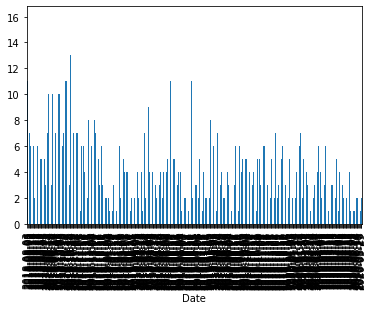

In [9]:
date = df_news.groupby('Date').size()
print(date.plot.bar())

In [10]:
def getYearMonth():
    data = new_dataset()
    data['Y_M'] = ""
    
    for i, x in data['Date'].iteritems():
        data['Y_M'].loc[i] = x.strftime('%Y-%m')
        
    return data

In [11]:
df_news = getYearMonth()

AxesSubplot(0.125,0.125;0.775x0.755)


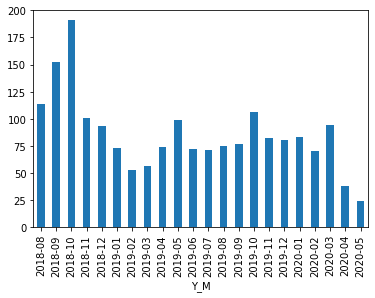

In [12]:
month = df_news.groupby('Y_M').size()
print(month.plot.bar())

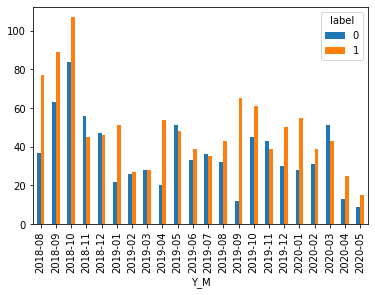

In [13]:
pd.crosstab(df_news['Y_M'],df_news['label']).plot.bar()

On utilise une visualition assez parlante et claire afin de voir quels sont les mots qui apparaissent le plus dans notre dataset:
    - les mots les plus récurrents dans nos titres d'articles
    - les mots les plus récurrents dans nos introductions d'articles 

In [14]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

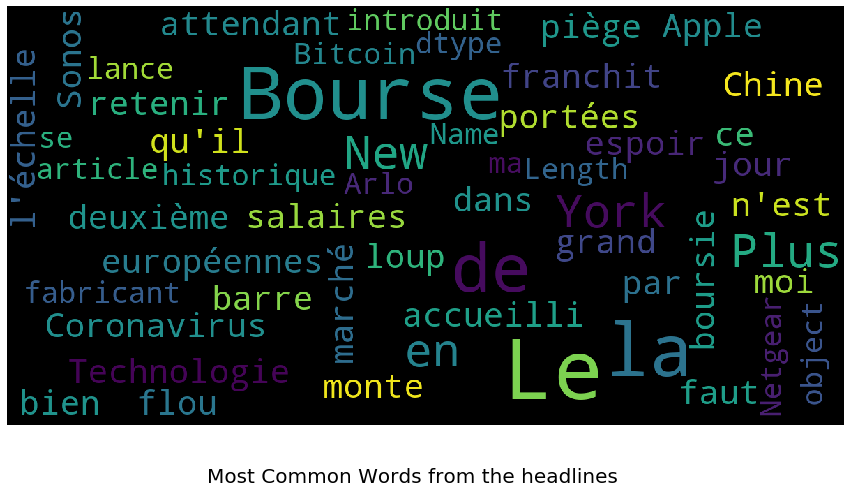

In [15]:
show_wordcloud(df_news['article'],'Most Common Words from the headlines')

On remarque que la plupart des mots présents dans notre corpus sont des mots trés présents dans la langue française:
    - pronom, conjontion de coordination , ...
    - Aussi la présence de même mot à cause de la ponctuation
On va donc essayer de les enlever afin d'avoir des mots plus parlants 

In [16]:
from nltk.corpus import stopwords

stop_words = stopwords.words('french')
print(stop_words)
df_news['article'] = df_news['article'].str.lower()

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

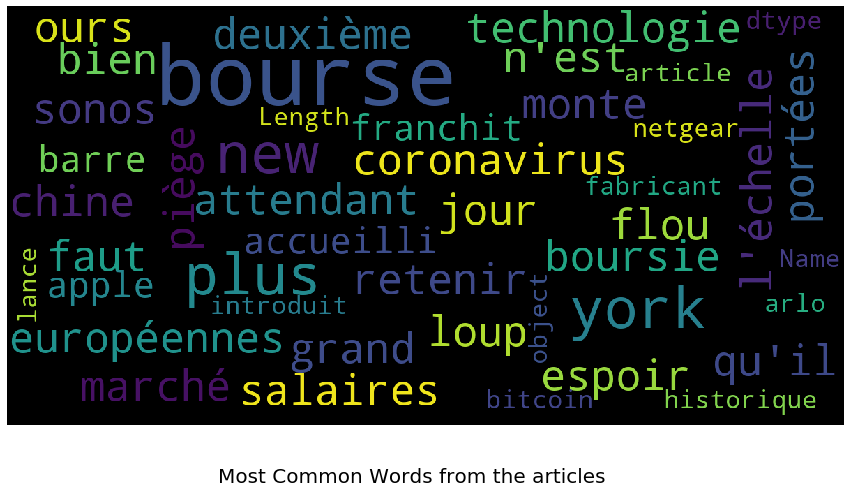

In [17]:
show_wordcloud(df_news['article'],'Most Common Words from the articles')

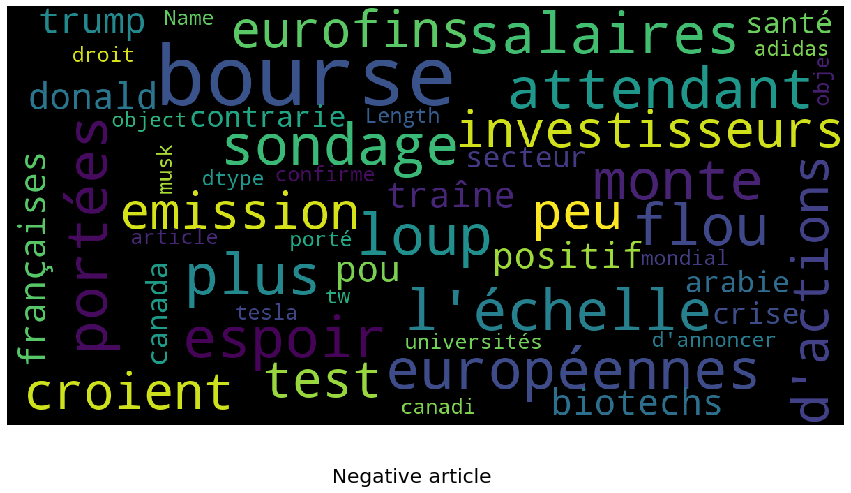

In [18]:
show_wordcloud(df_news[df_news['label'] == 0]['article'],'Negative article')

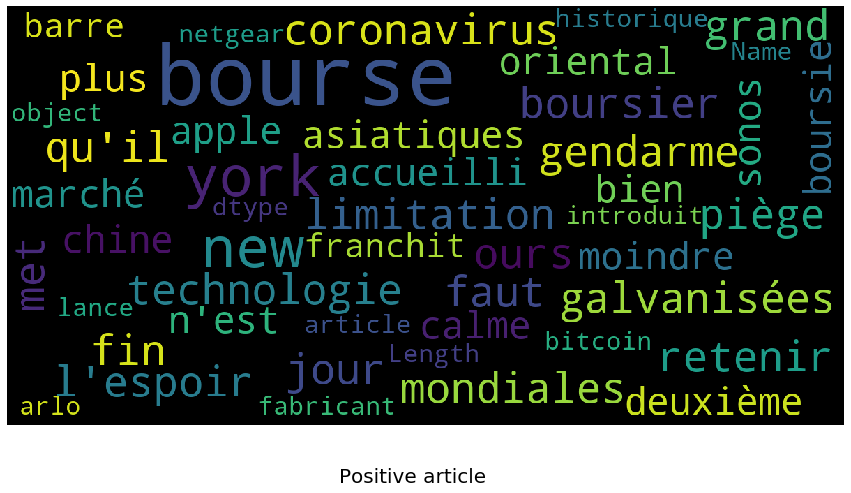

In [19]:
show_wordcloud(df_news[df_news['label'] == 1]['article'],'Positive article')